In [1]:
import os, cv2, warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from sklearn.metrics import f1_score
import multiprocessing as mp

from utils.Dataset import CustomAugmentation, CustomDataset
from utils.models import ResNet50, UnetResnet50
from utils.utils import dense_crf_wrapper, seed_everything

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
warnings.filterwarnings("ignore")

Dataloader

In [2]:
val_transform = CustomAugmentation('val')
val_dataset = CustomDataset(data_path='../data/QCdataset', mode='test', transform=val_transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=4,
                                        drop_last=False,
                                        pin_memory=(torch.cuda.is_available()),
                                        collate_fn=None)

Model load

In [3]:
# classification model
model_classification = ResNet50()
model_classification.load_state_dict(torch.load('./saved/best1.pt'))
model_classification = model_classification.to(device)

# segmentation classification
model_segmentation = UnetResnet50()
model_segmentation.load_state_dict(torch.load('./saved/seg1.pt').state_dict())
model_segmentation = model_segmentation.to(device)

model_seg_classification = ResNet50()
model_seg_classification.load_state_dict(torch.load('./saved/seg_class1.pt'))
model_seg_classification = model_seg_classification.to(device)

softmax = torch.nn.Softmax()
normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))

model_classification.eval()
model_segmentation.eval()
model_seg_classification.eval()
print()

image load

(-0.5, 223.5, 223.5, -0.5)

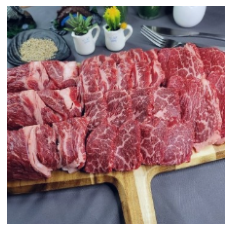

In [4]:
val_loader_iter = iter(val_loader)
image, label, mask = next(val_loader_iter)
# image, label, mask = next(val_loader_iter)

image, mask = image.to(device), mask.to(device)
#plot
image_unnorm = torch.div(torch.add(image, -image.min()),torch.add(image.max(), -image.min()))
plt.imshow(image_unnorm.squeeze().detach().cpu().numpy().transpose(1,2,0))
plt.axis('off')

classification result

In [5]:
output_classification = model_classification(image)
prob_classification = softmax(output_classification)
pred_classification = output_classification.argmax(1)

print(f'{output_classification.detach().cpu().numpy()}, {prob_classification.detach().cpu().numpy()}, {pred_classification.detach().cpu().numpy()}')

[[ 2.3759797 -8.122864   5.900569  -3.547892  -0.3678049]], [[2.8565830e-02 7.8751174e-07 9.6951944e-01 7.6408527e-05 1.8375377e-03]], [2]


classification result after segmentation

Text(0.5, 1.0, 'ground truth')

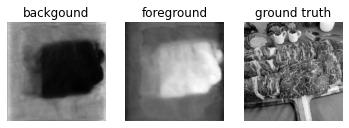

In [6]:
output_segmentation = model_segmentation(image)


# plot
fig, ax = plt.subplots(1, 3)
ax[0].imshow(output_segmentation.squeeze().detach().cpu().numpy()[0], cmap='gray')
ax[1].imshow(output_segmentation.squeeze().detach().cpu().numpy()[1], cmap='gray')
ax[2].imshow(mask.squeeze().detach().cpu().numpy(), cmap='gray')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title("backgound")
ax[1].set_title("foreground")
ax[2].set_title("ground truth")

threshold

Text(0.5, 1.0, 'ground truth')

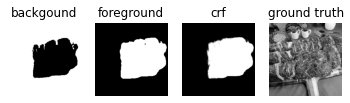

In [12]:
output_segmentation_th = torch.where(output_segmentation>0., 1., 0.)

# crf
image_unnorm = 255*torch.div(torch.add(image, -image.min()),torch.add(image.max(), -image.min()))
probs_seg = torch.nn.functional.softmax(output_segmentation, dim=1).detach().cpu().numpy()

pool = mp.Pool(mp.cpu_count())
images_rgb = image_unnorm.detach().cpu().numpy().astype(np.uint8).transpose(0, 2, 3, 1)
probs_crf = np.array(pool.map(dense_crf_wrapper, zip(images_rgb, probs_seg)))
pool.close()
probs_crf = torch.tensor(probs_crf).to(device)

# plot
fig, ax = plt.subplots(1, 4)
ax[0].imshow(output_segmentation_th.squeeze().detach().cpu().numpy()[0], cmap='gray')
ax[1].imshow(output_segmentation_th.squeeze().detach().cpu().numpy()[1], cmap='gray')
ax[2].imshow(probs_crf.squeeze().detach().cpu().numpy()[1], cmap='gray')
ax[3].imshow(mask.squeeze().detach().cpu().numpy(), cmap='gray')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[0].set_title("backgound")
ax[1].set_title("foreground")
ax[2].set_title("crf")
ax[3].set_title("ground truth")

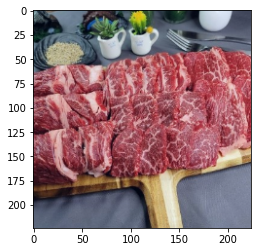

In [13]:
plt.imshow(images_rgb[0])

masked image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'ground truth')

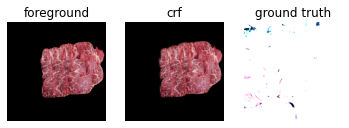

In [17]:

masked_seg_image = torch.mul(image_unnorm, torch.stack([output_segmentation_th.squeeze()[1]]*3, dim=0).unsqueeze(0)).squeeze().detach().cpu().numpy().transpose(1, 2, 0)/255
masked_crf_image = torch.mul(image_unnorm, torch.stack([probs_crf.squeeze()[1]]*3, dim=0).unsqueeze(0)).squeeze().detach().cpu().numpy().transpose(1, 2, 0)/255
masked_gt_image = torch.mul(image_unnorm, torch.stack([mask.squeeze()]*3, dim=0).unsqueeze(0)).squeeze().detach().cpu().numpy().transpose(1, 2, 0)/255

# plot
fig, ax = plt.subplots(1, 3)
ax[0].imshow(masked_seg_image)
ax[1].imshow(masked_crf_image)
ax[2].imshow(masked_gt_image)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title("foreground")
ax[1].set_title("crf")
ax[2].set_title("ground truth")


classification after seg

In [18]:
input_seg_classification = normalize(torch.tensor(masked_seg_image).permute(2,0,1))
input_gt_classification = normalize(torch.tensor(masked_gt_image).permute(2,0,1))
input_seg_classification, input_gt_classification = input_seg_classification.unsqueeze(0).to(device), input_gt_classification.unsqueeze(0).to(device)

masked_crf_images = torch.mul(image_unnorm, torch.stack([probs_crf[:,1,:,:]]*3, dim=1)).squeeze().detach().cpu()
masked_crf_images = normalize(masked_crf_images)
input_crf_classification = masked_crf_images.unsqueeze(0).to(device)

# seg masked image classification
output_seg_classification = model_seg_classification(input_seg_classification)
prob_seg_classification = softmax(output_seg_classification)
pred_seg_classification = output_seg_classification.argmax(1)
# crf masked image classification
output_crf_classification = model_seg_classification(input_crf_classification)
prob_crf_classification = softmax(output_crf_classification)
pred_crf_classification = output_crf_classification.argmax(1)
# gt masked image classification
output_gt_classification = model_seg_classification(input_gt_classification)
prob_gt_classification = softmax(output_gt_classification)
pred_gt_classification = output_gt_classification.argmax(1)

print(f'{output_seg_classification.detach().cpu().numpy()}, {prob_seg_classification.detach().cpu().numpy()}, {pred_seg_classification.detach().cpu().numpy()}')
print(f'{output_crf_classification.detach().cpu().numpy()}, {prob_crf_classification.detach().cpu().numpy()}, {pred_crf_classification.detach().cpu().numpy()}')
print(f'{output_gt_classification.detach().cpu().numpy()}, {prob_gt_classification.detach().cpu().numpy()}, {pred_gt_classification.detach().cpu().numpy()}')

[[-2.2614923 -2.0456748 -1.3604168  3.1917052 -0.8089154]], [[0.00412404 0.00511742 0.01015441 0.9629775  0.0176266 ]], [3]
[[ -128.65073   492.4951   -162.87186 -2286.3982   1171.802  ]], [[0. 0. 0. 0. 1.]], [4]
[[ -340.37952   297.55765   150.50502 -2851.078    1593.5712 ]], [[0. 0. 0. 0. 1.]], [4]


final result

In [19]:
print(f'{output_classification.detach().cpu().numpy()}, {prob_classification.detach().cpu().numpy()}, {pred_classification.detach().cpu().numpy()}')
print(f'{output_seg_classification.detach().cpu().numpy()}, {prob_seg_classification.detach().cpu().numpy()}, {pred_seg_classification.detach().cpu().numpy()}')
print(f'{output_crf_classification.detach().cpu().numpy()}, {prob_crf_classification.detach().cpu().numpy()}, {pred_crf_classification.detach().cpu().numpy()}')
print(f'{output_gt_classification.detach().cpu().numpy()}, {prob_gt_classification.detach().cpu().numpy()}, {pred_gt_classification.detach().cpu().numpy()}')


print(f'class: {pred_classification.detach().cpu().numpy()}, seg_class: {pred_seg_classification.detach().cpu().numpy()}', end=' ')
print(f'crf_class: {pred_crf_classification.detach().cpu().numpy()}, gt_class: {pred_gt_classification.detach().cpu().numpy()}, gt: {label[0]}')
print('class: ', end=" ")
for prob in prob_classification.detach().cpu().numpy()[0]:
    print(f'{100*prob:.2f}%', end=" ")
print()
print('seg_class: ', end=" ")
for prob in prob_seg_classification.detach().cpu().numpy()[0]:
    print(f'{100*prob:.2f}%', end=" ")
print()
print('crf_class: ', end=" ")
for prob in prob_crf_classification.detach().cpu().numpy()[0]:
    print(f'{100*prob:.2f}%', end=" ")
print()
print('gt_class: ', end=" ")
for prob in prob_gt_classification.detach().cpu().numpy()[0]:
    print(f'{100*prob:.2f}%', end=" ")
print()

[[ 2.3759797 -8.122864   5.900569  -3.547892  -0.3678049]], [[2.8565830e-02 7.8751174e-07 9.6951944e-01 7.6408527e-05 1.8375377e-03]], [2]
[[-2.2614923 -2.0456748 -1.3604168  3.1917052 -0.8089154]], [[0.00412404 0.00511742 0.01015441 0.9629775  0.0176266 ]], [3]
[[ -128.65073   492.4951   -162.87186 -2286.3982   1171.802  ]], [[0. 0. 0. 0. 1.]], [4]
[[ -340.37952   297.55765   150.50502 -2851.078    1593.5712 ]], [[0. 0. 0. 0. 1.]], [4]
class: [2], seg_class: [3] crf_class: [4], gt_class: [4], gt: 0
class:  2.86% 0.00% 96.95% 0.01% 0.18% 
seg_class:  0.41% 0.51% 1.02% 96.30% 1.76% 
crf_class:  0.00% 0.00% 0.00% 0.00% 100.00% 
gt_class:  0.00% 0.00% 0.00% 0.00% 100.00% 
